# Hierarchical Linear Regression (Radon Contamination dataset)

In this example we want to revisit the classical example of hierarchical linear regression model based on the dataset of the *Radon Contamination* by Gelman and Hill. In particular, we want to show how to easy is to port the [`pymc`](https://docs.pymc.io/en/v3/) models, presented in the very complete article [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html), to [`bambi`](https://bambinos.github.io/bambi/main/index.html) using the formula specification for the models.

## Prepare Notebook

In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import pandas as pd
import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns

az.style.use("arviz-darkgrid")
np.random.default_rng(8924)

%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = "svg"

## Read Data

Let us load the data into a pandas dataframe.

In [2]:
path = "https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/srrs2.dat"
srrs2 = pd.read_csv(path)

## Preprocess Data

Let us start by preprocessing the data as done in the article [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html). We want to keep the same notation as in the article.

In [3]:
# TODO: Organize this pre-processing steps and keep just the relevant ones.

# Filter data for state `MN`
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

# Compute fips
srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips

# Get city data
cty = pd.read_csv(pm.get_data("cty.dat"))
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

# Merge data
srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

# Get lookup table for counties
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(counties)))

# local copies of variables
county = srrs_mn["county_code"] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor = srrs_mn.floor.values

srrs_mn.sort_values(by="floor", inplace=True)

# Map 0 -> Basement and 1 -> Floor
srrs_mn["floor"] = srrs_mn["floor"].map({0: "Basement", 1: "Floor"})

## EDA

Let us do some exploratory data analysis. To get a glimpse of the data we are going to use. First Let us see global `log_radon` distribution.

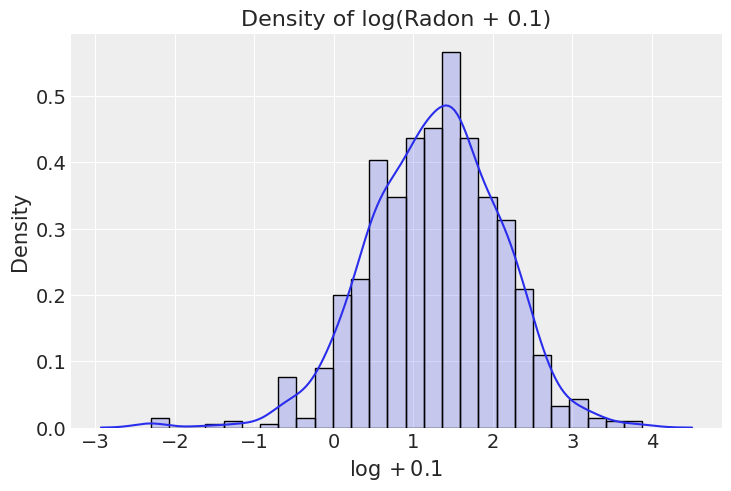

In [4]:
fig, ax = plt.subplots()
sns.histplot(x="log_radon",  alpha=0.2, stat="density", data=srrs_mn, ax=ax)
sns.kdeplot(x="log_radon", data=srrs_mn, ax=ax)
ax.set(title="Density of log(Radon + 0.1)", xlabel="$\log + 0.1$", ylabel="Density");

Let us now se the split per `floor`:

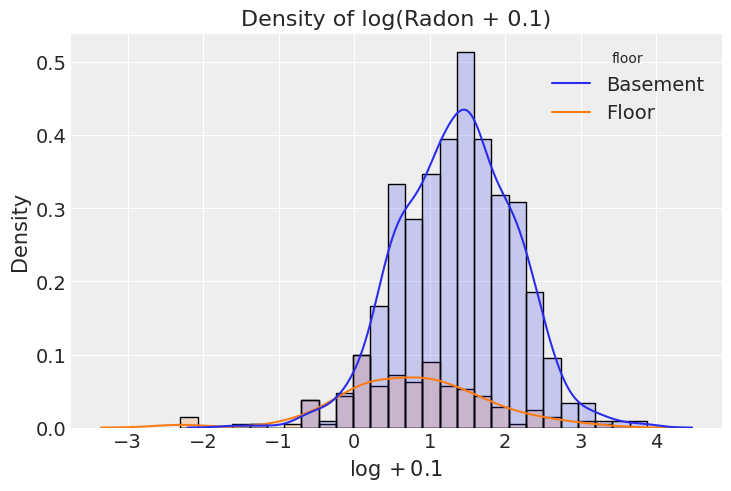

In [5]:
fig, ax = plt.subplots()
sns.histplot(x="log_radon", hue="floor", alpha=0.2, stat="density", data=srrs_mn, ax=ax)
sns.kdeplot(x="log_radon", hue="floor", data=srrs_mn, ax=ax)
ax.set(title="Density of log(Radon + 0.1)", xlabel="$\log + 0.1$", ylabel="Density");

Next, let us count the number of counties.

In [6]:
print(f"Number of counties: {srrs_mn['county'].unique().size}")

Number of counties: 85


Let us dig deeper into the distribution of radon per county and floor level.

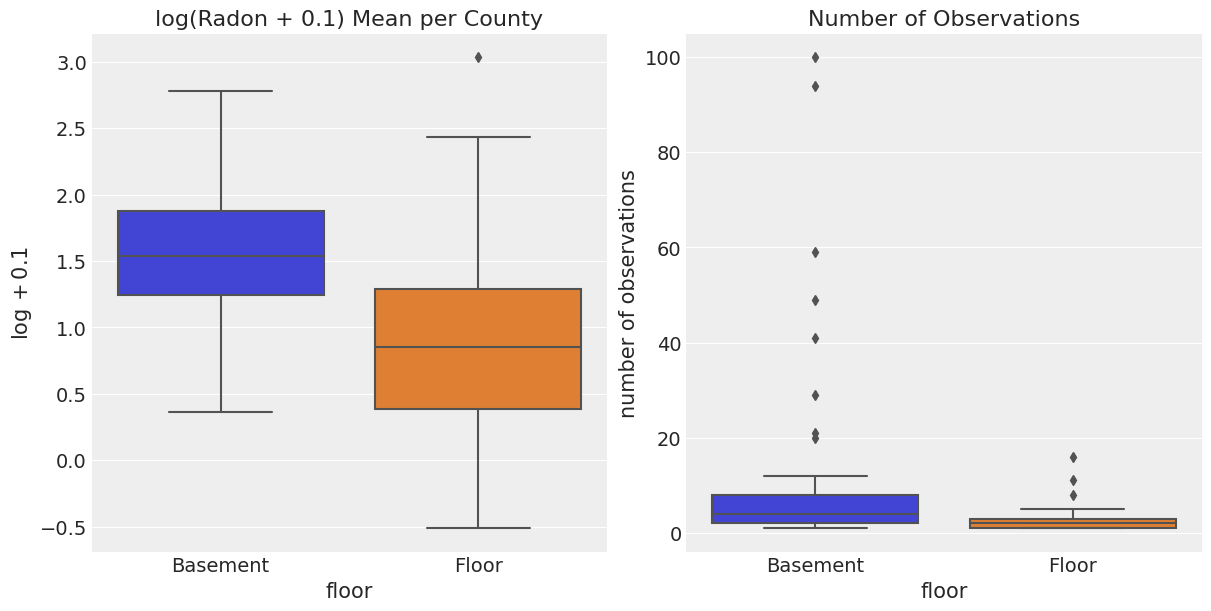

In [7]:
log_radon_county_agg  = (
    srrs_mn 
    .groupby(["county", "floor"], as_index=False)
    .agg(
        log_radon_mean=("log_radon", "mean"),
        n_obs=("log_radon", "count")
    )
)

fig, ax= plt.subplots(nrows=1, ncols=2, figsize=(12, 6), layout="constrained")
sns.boxplot(x="floor", y="log_radon_mean", data=log_radon_county_agg, ax=ax[0])
ax[0].set(title="log(Radon + 0.1) Mean per County", ylabel="$\log + 0.1$");
sns.boxplot(x="floor", y="n_obs", data=log_radon_county_agg, ax=ax[1])
ax[1].set(title="Number of Observations", xlabel="floor", ylabel="number of observations");

We see that there are some counties with a lot of basement observations. This can create some bias when computing simple statistics to compare across counties. Moreover, not all `county` and `floor` combinations are present in the dataset. For example:

In [8]:
assert srrs_mn.query("county == 'YELLOW MEDICINE' and floor == 'Floor'").empty

## Models: Conventional Approaches

### Complete Pooling

> [StartEdit] Feel free to change the wording or the order of the ideas. I wanted to add this because it is a more accurate description of the model. It's equivalent to the PyMC model, the different is that the Bambi model uses a different parametrisations. In particular I like having beta_1 and beta_2 instead of beta_1 * x_i. The latter reminds me of numerical/continuous predictors, when it is actually either 0 or 1.

For this first model we only consider the predictor `floor`, which represents the floor level. The following equation describes the linear model that we are going to build with Bambi

$$
y_{i,j} = \beta_i + \varepsilon_{i, j}
$$

where $i$ indexes the floor levels and $j$ indexes the different measurements made. In other words, $i$ takes the values 1 = Basement and 2 = Floor, while $j$ ranges from 1 to $n$.

$y_{i, j}$ is the logarithm of the radon level plus 0.1 for the $j$-th measurement and $i$-th floor level. 

$\beta_i$ is the model coefficient for the $i$-th floor level. For measurements in the Basement, i.e. when $i=1$, the model predicts

$$
y_{1,j} = \beta_1 
$$

and for measurements in the Floor, i.e. when $i=2$, the model predicts

$$
y_{2,j} = \beta_2
$$

In other words, the prediction for all the measurements in the Basement level is $\beta_1$, while the prediction for all the measurements in the Floor level is $\beta_2$, no matter for which measurement we're making the prediction.

Finally, $\varepsilon_{i, j}$ is the random variable that explains the difference between the observed measurement $y_{i, j}$ and the predicted value $\beta_i$. 


**Note:** We still need to add something about the meaning of _pooling_. In this Radon example, the pooling refers to what we do with the different Counties when we compute estimates (i.e. this does not refer to pooling across floor levels). In this case, _Complete pooling_ means that all the measurements for all counties are pooled into a single estimate ("treat all counties the same"), conditional on the floor level (because we are using floor as a covariate/predictor).

I tried to clarify terms as much as possible. We, statisticians, made such much harm with all the different ways of referring to the same thing 😅

>[EndEdit]

Let us start by considering the complete pooling model on which we treat all counties the same and estimate a single radon level for every floor level. That is, We want to estimate the intercept ($\alpha$) and the slope ($\beta$) parameters for the equation:

$$y_i = \alpha + \beta x_i + \varepsilon_i, \quad \text{with} \: i=1, \cdots, n$$

where $y_i$ represents the `log_radon`, $x_i$ represents the `floor` and $\varepsilon_i \sim N(0, \sigma^2_y)$ represents the `radon` noise. As we want to make the results of this notebook comparable with the original PyMC article, we use the full one-hot-encoding of the `floor` variable. This means that we do not need to add an intercept variable, i.e. we set $\alpha$ to zero. Besides the model specification, we also need to set prior distributions for $\beta$ and $\sigma$. We consider the following (as in the PyMC article):

$$
\begin{align*}
\beta & \sim N(0, 10^{2}) \\
\sigma & \sim Exp(1.0)
\end{align*}
$$

Let us now write the Bambi model:

In [9]:
pooled_priors = {
    "floor": bmb.Prior(name="Normal", mu=0.0, sigma=10.0),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

pooled_model = bmb.Model(
    formula="log_radon ~ 0 + floor",
    data=srrs_mn,
    priors=pooled_priors,
    family="gaussian",
    link="identity",
    auto_scale=False,
    noncentered=False,
)

pooled_model

Formula: log_radon ~ 0 + floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    floor ~ Normal(mu: 0.0, sigma: 10.0)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

Here are some remarks:

- The formula for the model is `log_radon ~ 0 + floor`. The `0` at the beginning makes sure we remove the intercept.
- We use a non-centered parameterization of the model and do not scale the data just to make the results comparable with the original PyMC article.

> [StartEdit] 

- The `0` at the beginning makes sure we remove the intercept, which allows the model to use one coefficient for each floor level.
- There's no need to talk about centered vs non-centered parametrisations here because that refers to group-specific (aka varying, aka random) effects. So far this model has only one common (aka fixed) effect which is the floor level.
- Also `autoscale` is not needed here because we're passing priors by hand

>[EndEdit]

Let us fit he model now:

In [10]:
pooled_results = pooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, floor]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


Let us see the graph representation of the model:

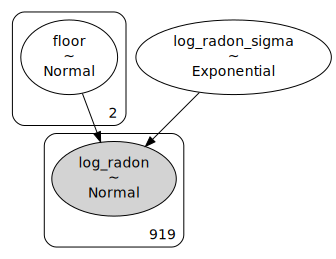

In [11]:
pooled_model.graph()

Now we can examine the posterior distribution of the model parameters:

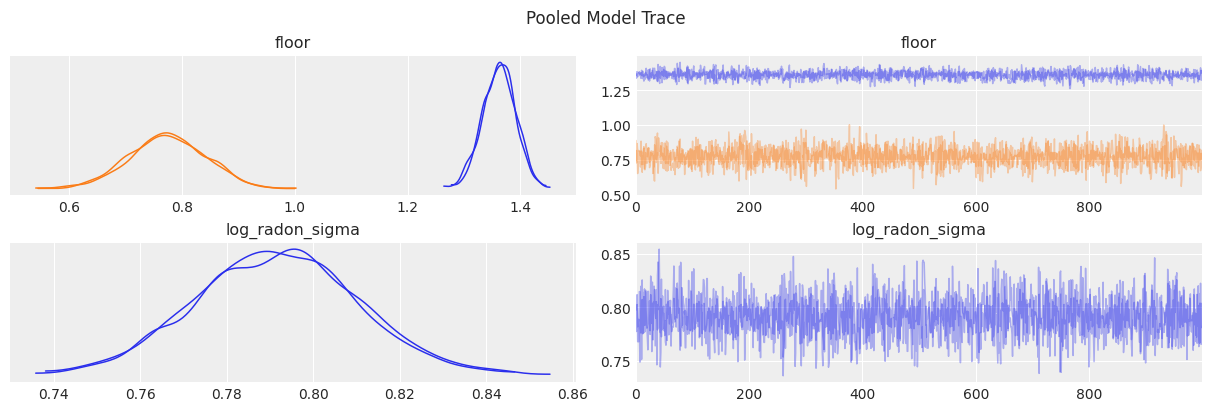

In [12]:
az.plot_trace(data=pooled_results, compact=True, chain_prop={"ls": "-"});
plt.suptitle("Pooled Model Trace");

We can now see some summary statistics. 

In [13]:
pooled_summary = az.summary(data=pooled_results)
pooled_summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
floor[Basement]  1.362  0.029   1.304    1.414      0.001    0.000    2504.0   
floor[Floor]     0.774  0.068   0.644    0.896      0.001    0.001    2533.0   
log_radon_sigma  0.791  0.019   0.757    0.827      0.000    0.000    2390.0   

                 ess_tail  r_hat  
floor[Basement]    1381.0    1.0  
floor[Floor]       1370.0    1.0  
log_radon_sigma    1509.0    1.0

> [StartEdit] I think it would be interesting to interpret the results in the posterior. Something along the following lines:

From the posterior plot and the summary, we can see the mean radon level is considerably higher in the Basement than in the Floor level.

If we transform the results back to the original measurement scale we have

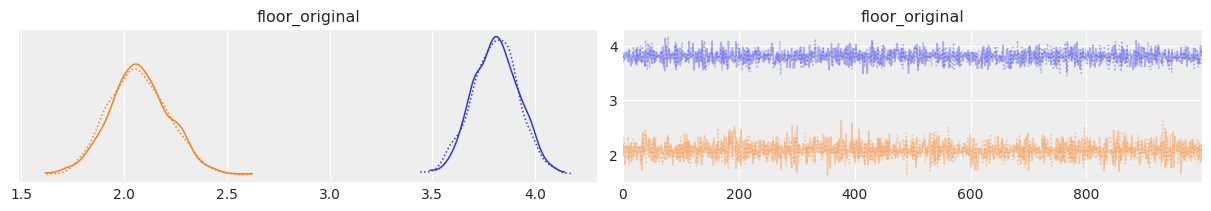

In [14]:
pooled_results.posterior["floor_original"] = np.exp(pooled_results.posterior["floor"]) - 0.1

az.plot_trace(pooled_results, var_names=["floor_original"]);

In [15]:
# I don't understand why these mean don't match the posterior ones
srrs_mn.groupby("floor")["activity"].mean()

floor
Basement    5.065666
Floor       3.278431
Name: activity, dtype: float64

In [16]:
az.summary(pooled_results)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
floor[Basement]           1.362  0.029   1.304    1.414      0.001    0.000   
floor[Floor]              0.774  0.068   0.644    0.896      0.001    0.001   
log_radon_sigma           0.791  0.019   0.757    0.827      0.000    0.000   
floor_original[Basement]  3.807  0.113   3.577    4.002      0.002    0.002   
floor_original[Floor]     2.074  0.148   1.792    2.335      0.003    0.002   

                          ess_bulk  ess_tail  r_hat  
floor[Basement]             2504.0    1381.0    1.0  
floor[Floor]                2533.0    1370.0    1.0  
log_radon_sigma             2390.0    1509.0    1.0  
floor_original[Basement]    2504.0    1381.0    1.0  
floor_original[Floor]       2533.0    1370.0    1.0

>[EndEdit]

We can compare the mean of the posterior distribution of the `floor` terms to the sample mean:

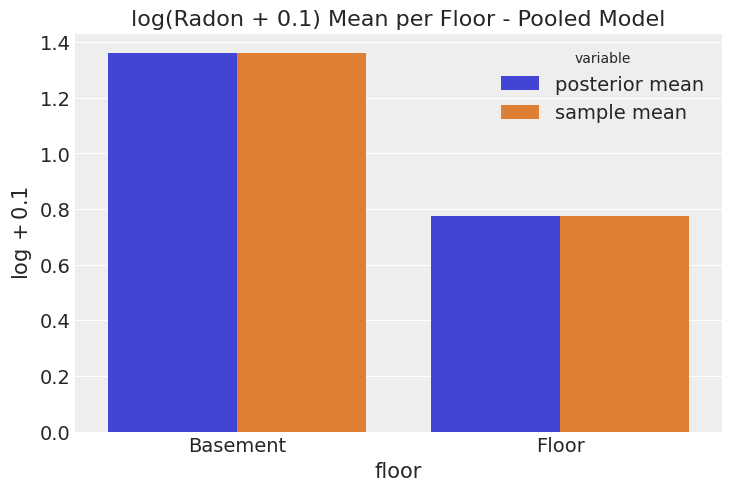

In [17]:
fig, ax = plt.subplots()

pooled_summary["mean"] \
    .iloc[:-1] \
    .reset_index() \
    .assign(floor = lambda x: x["index"].str.slice(6, -1).str.strip()) \
    .merge(
        right=srrs_mn.groupby(["floor"])["log_radon"].mean(),
        left_on="floor",
        right_index=True
    ) \
    .rename(columns={
        "mean": "posterior mean",
        "log_radon": "sample mean"
    }) \
    .melt(
        id_vars="floor",
        value_vars=["posterior mean", "sample mean"]
    ) \
    .pipe((sns.barplot,"data"),
        x="floor",
        y="value",
        hue="variable",
        ax=ax
    )

ax.set(
    title="log(Radon + 0.1) Mean per Floor - Pooled Model",
    ylabel="$\log + 0.1$"
);

We see that estimation for the observations in either group is the group mean (plus the smoothing because of the prior).

### No Pooling

> [StartEdit] Some content may be redundant. Feel free to remove anything you want.

Now the predictor is the interaction between `floor` and `county`. The following equation describes the linear model that we are going to build with Bambi

$$
y_{i, j, k} = \gamma_{i, j} + \varepsilon_{i, j, k}
$$

where $i$ indexes the floor levels, $j$ indexes the counties, and $k$ indexes the different measurements made. As before, $i$ takes the values 1 = Basement and 2 = Floor, but now $j$ ranges from 1 to $85$, the number of counties, and $k$ ranges from $1$ to $n$, the number of measurements.

$y_{i, j, k}$ is the logarithm of the radon level plus 0.1 for the $k$-th measurement in the $i$-th floor level and $j$-th county. 

$\gamma_{i, j}$ is the coefficient for the interaction between `floor` and `county`. It repreesents the effect of the $i$-th floor and the $j$-th county.

In this second model, the prediction for a given measurement will depend both on the floor level as well as the county.

This interaction coefficient allows the `floor` effect to be different in the different counties.

And again, $\varepsilon_{i, j, k}$ is the random variable that explains the difference between the observed measurement $y_{i, j, k}$ and the predicted value $\gamma_{i, j}$. 


**Note:** More comments about pooling _pooling_. Now County enters as a predictor, and it enters in an interaction effect with floor. This means the county effect can be different for each radon level (or as I said above, the floor effect can be different for each county). This interaction is what allows the _no pooling_ to take place. In this case, _no pooling_ means that none of the measurement of a given country affects in the computation of the coefficient for another county. That's why, in the end, the estimation for each combination of county and floor level is the mean of the measurements in that county and floor level.

**Another comment** you may note this model takes longer in Bambi than in PyMC. That's because Bambi computes the dot product of the design matrix, which in this case is very sparse (2 * 85 columns), and the vector of coefficients. This means we have a lot of meaningless multiplications (they are just 0). I'm trying to work on a better algorithm to improve this.

>[EndEdit]


Next, we consider the model in which radon is modeled for each `county` and `floor` combination independently, i.e. 

$$y_i = \alpha_{j[i]} + \beta x_i + \varepsilon_i \quad \text{where} \: j = 1,\ldots,85$$

As above, we actually set $\alpha_{j[i]} = 0$ (as we consider the full one-hot-encoding of the variables). Note that for in this case $x_i$ now represents the product of the floor level times the county (as indicator functions). To specify this model in Bambi we can use the formula `log_radon ~ 0 + county:floor`. Note that we are removing the intercept with the `0` term and `county:floor` is the multiplicative interaction between `county` and `floor`. We consider similar priors as above. Let us run the Baby model:

In [18]:
unpooled_priors = {
    "county:floor": bmb.Prior(name="Normal", mu=0.0, sigma=10.0),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

unpooled_model = bmb.Model(
    formula="log_radon ~ 0 + county:floor",
    data=srrs_mn,
    priors=unpooled_priors,
    family="gaussian",
    link="identity",
    auto_scale=False,
    noncentered=False,
)

unpooled_model

Formula: log_radon ~ 0 + county:floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    county:floor ~ Normal(mu: 0.0, sigma: 10.0)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

In [19]:
unpooled_results = unpooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, county:floor]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 37 seconds.


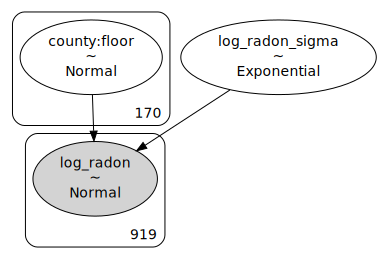

In [20]:
unpooled_model.graph()

From the graph representation of the model we see that the we are estimating $170 = 82 \times 2$ parameters from the `county:floor` interaction. Let us now compute the summary statistics of the model.

We can now see the posterior sample plot distributions:

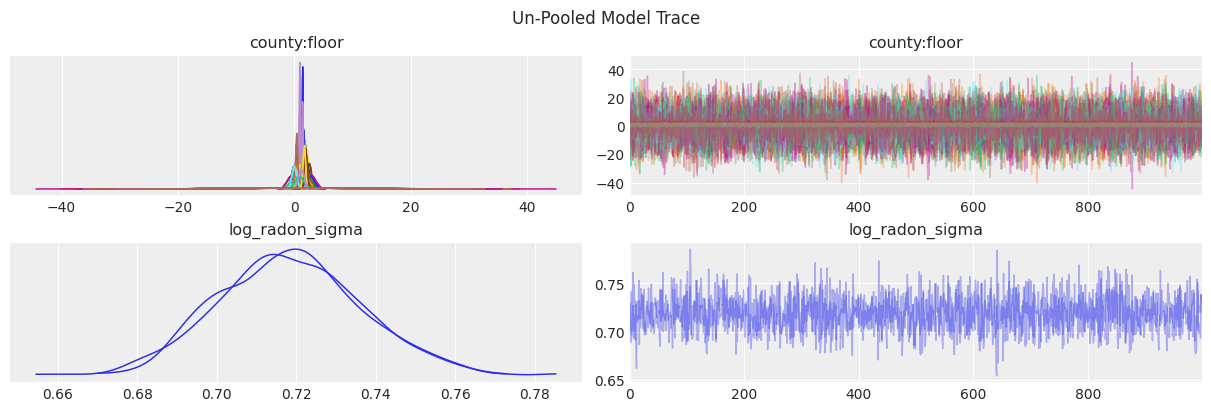

In [21]:
az.plot_trace(data=unpooled_results, compact=True, chain_prop={"ls": "-"});
plt.suptitle("Un-Pooled Model Trace");

To obtain a better summary visualization we can use a forest plot:

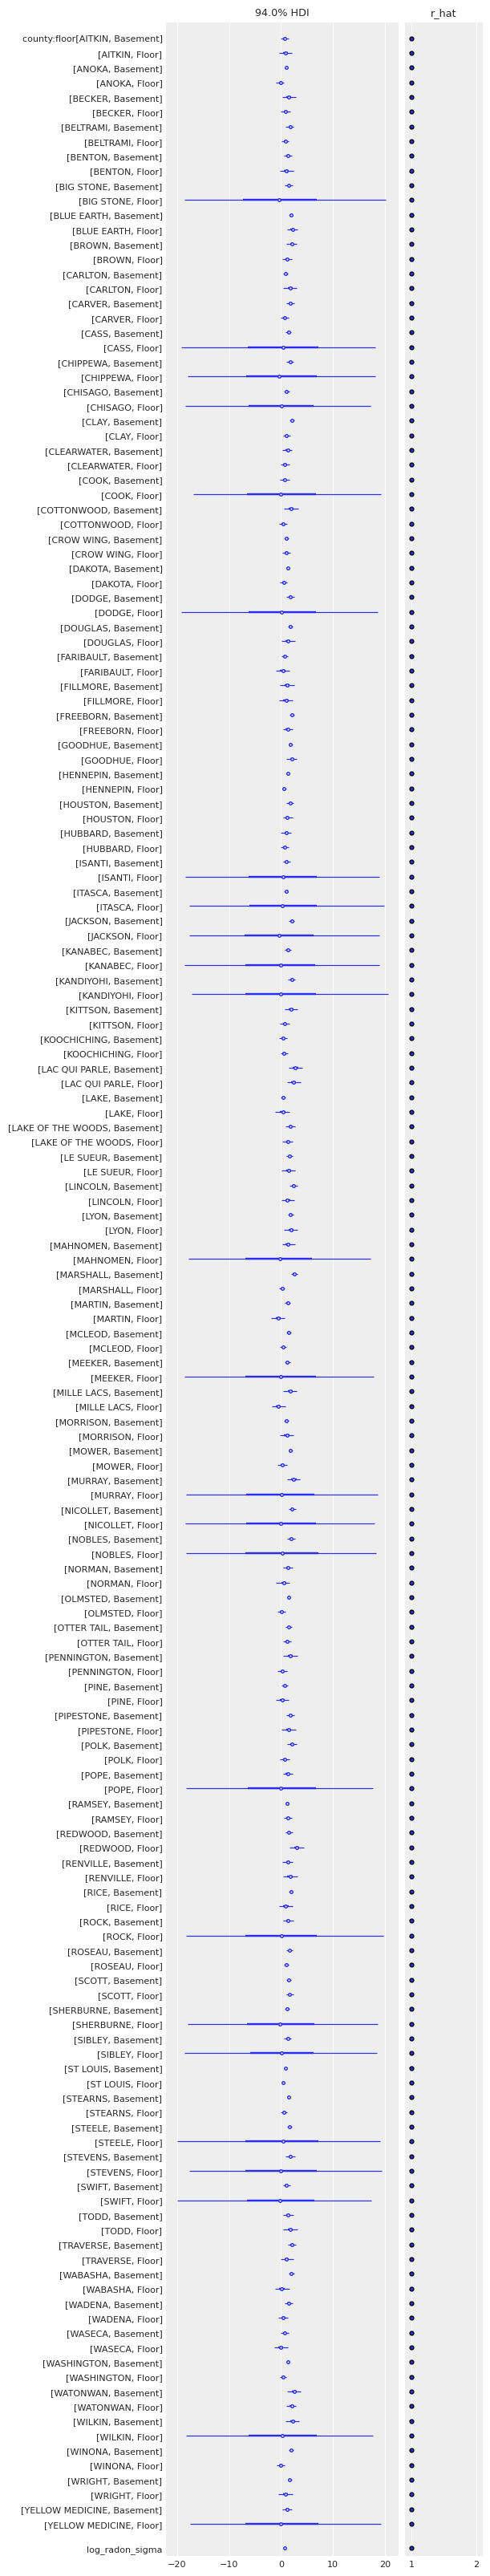

In [22]:
az.plot_forest(data=unpooled_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

Note how for the combination `county == 'YELLOW MEDICINE' and floor == 'Floor'` where we do not have any observations, the model can still generate predictions which are essentially coming from the prior distributions, which explains the large hdi intervals.

Next let us look into the posterior mean for each `county` and `floor` combination:

In [23]:
unpooled_summary = az.summary(data=unpooled_results)

We can now plot the posterior distribution mean of the beta coefficients against the observed values.

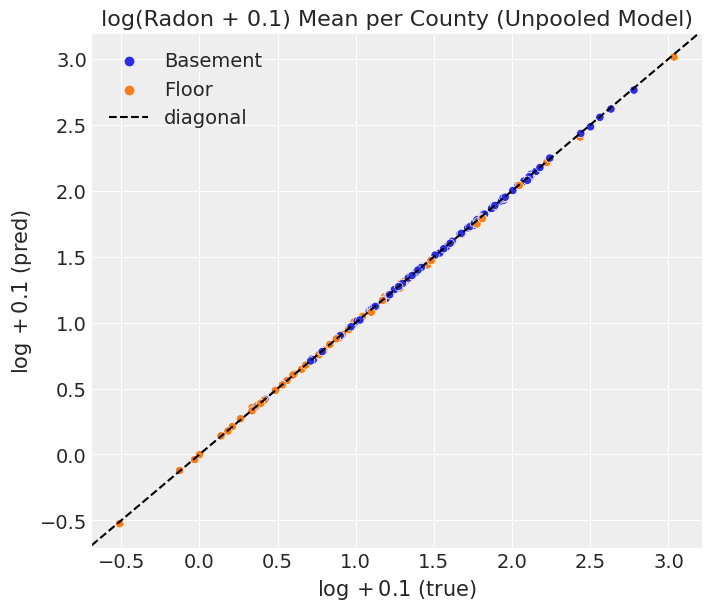

In [24]:
# Get county and floor names from summary table
var_mapping = unpooled_summary \
    .iloc[:-1] \
    .reset_index(drop=False) \
    ["index"] .str.slice(13, -1).str.split(",").apply(pd.Series)

var_mapping.rename(columns={0: "county", 1: "floor"}, inplace=True)
var_mapping["county"] = var_mapping["county"].str.strip()
var_mapping["floor"] = var_mapping["floor"].str.strip()
var_mapping.index = unpooled_summary.iloc[:-1].index
    
# merge with observed values
unpooled_summary_2 = pd.concat([var_mapping, unpooled_summary.iloc[:-1]], axis=1)


fig, ax = plt.subplots(figsize=(7, 6))
unpooled_summary_2 \
    .merge(right=log_radon_county_agg, on=["county", "floor"], how="left") \
    .pipe((sns.scatterplot, "data"),
        x="log_radon_mean",
        y="mean",
        hue="floor",
        ax=ax
    )
ax.axline(xy1=(1.0, 1.0), slope=1.0, color="black", linestyle="--", label="diagonal")
ax.legend()
ax.set(
    title="log(Radon + 0.1) Mean per County (Unpooled Model)",
    xlabel="$\log + 0.1$ (true)",
    ylabel="$\log + 0.1$ (pred)",
);

As expeced, the values strongly concentrated along the diagonal.

## Multilevel and Hierarchical Models

In this section we are going to explore various types of hierarchical models.If you're familiar with the PyMC way of using hierarchies, the Bambi way (borrowed from mixed effects models way) may be a bit confusing in the beginning, but as we will see, the notation is very convenient. A good explanation is found in Chapter 16 from Bayes Rules book, specifically section 16.3.2. Moreover, you can also take a look into the [Bambi examples section](https://bambinos.github.io/bambi/main/examples.html) where you can fin other use cases.

### Partial Pooling Model

We start with the *partial pooling model*, in which we estimate the radon level for each `county` (not considering `floor` for now) with the additional ingredient that we use a *hyper-prior* distribution over the intercept parameters. Concretely, we want to fit an intercept model

$$y_i = \alpha_{j[i]} + \varepsilon_i$$

where $\varepsilon_i \sim N(0, \sigma_y^2)$ and the intercept random effect is parametrized as $\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$. The hyper-prior is specified as 

$$
\begin{align*}
\mu_{\alpha} & \sim N(0, 10^{2}) \\
\sigma_{\alpha} & \sim Exp(1.0)
\end{align*}
$$

Let us see how to specify this model in Bambi:

In [25]:
# We can add the hyper-priors inside the prior dictionary parameter of the model constructor
partial_pooling_priors = {
    "Intercept": bmb.Prior("Normal", mu=0.0, sigma=10),
    "1|county": bmb.Prior(name="Normal", mu=0.0, sigma=bmb.Prior(name="Exponential", lam=1)),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

partial_pooling_model = bmb.Model(
    formula="log_radon ~ 1 + (1|county)", 
    data=srrs_mn, 
    priors=partial_pooling_priors,
    family="gaussian",
    link="identity",
    auto_scale=False,
    noncentered=False,
)

partial_pooling_model

Formula: log_radon ~ 1 + (1|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0.0, sigma: 10)

  Group-level effects
    1|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1))

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

For the partial pooling model we use the formula `log_radon ~ 1 + (1|county)`. Let us break down the model specification:
- The `(1|county)` is a varying effect, where we want each `county` to have a different intercept.
- The `1` at the beginning makes sure we add the intercept. Why do we add and intercept? Well, this is just because we can actually re-write $\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$ as $\alpha_{j[i]} \sim \mu_{\alpha} + N(0, \sigma_{\alpha}^2)$.
- Now it should be clear why we split de hyper-prior into two terms in `partial_pooling_priors`. The hyper-prior of the mean is assigned to the `Intercept` and the hyper-prior of the standard deviation is assigned to the varying effect term `(1|county)`.

Let us fit the model:

In [26]:
partial_pooling_results = partial_pooling_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, 1|county, 1|county_sigma, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
The number of effective samples is smaller than 25% for some parameters.


We can inspect the graphical representation of the model:

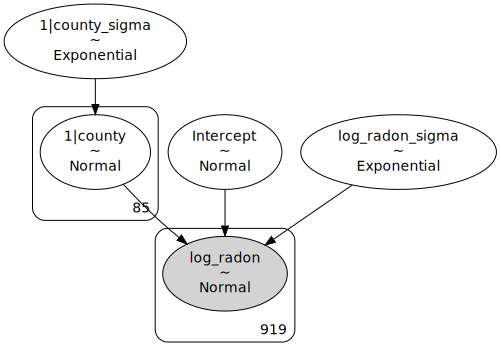

In [27]:
partial_pooling_model.graph()

We can clearly see a new hierarchical level as compared to the complete pooling model and unpooled model.

Next, we can plot the posterior distribution of the intercepts:

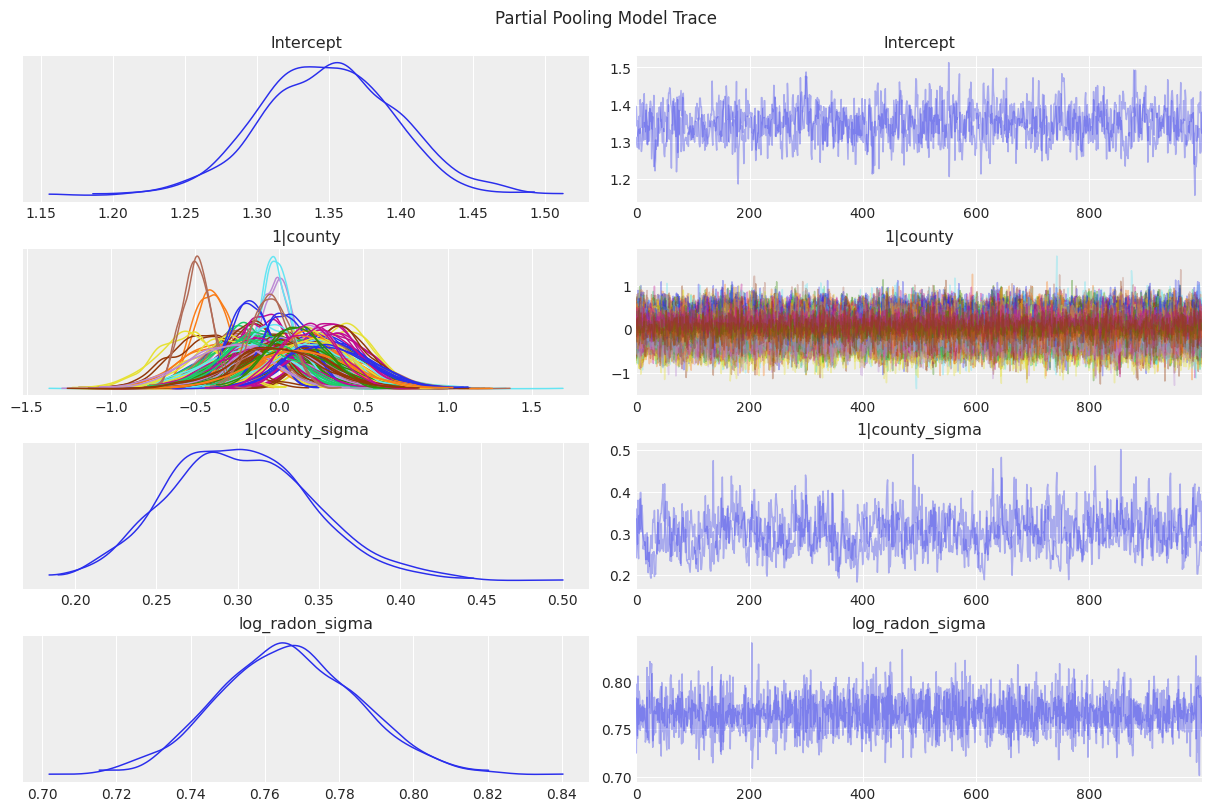

In [28]:
az.plot_trace(data=partial_pooling_results, compact=True, chain_prop={"ls": "-"});
plt.suptitle("Partial Pooling Model Trace");

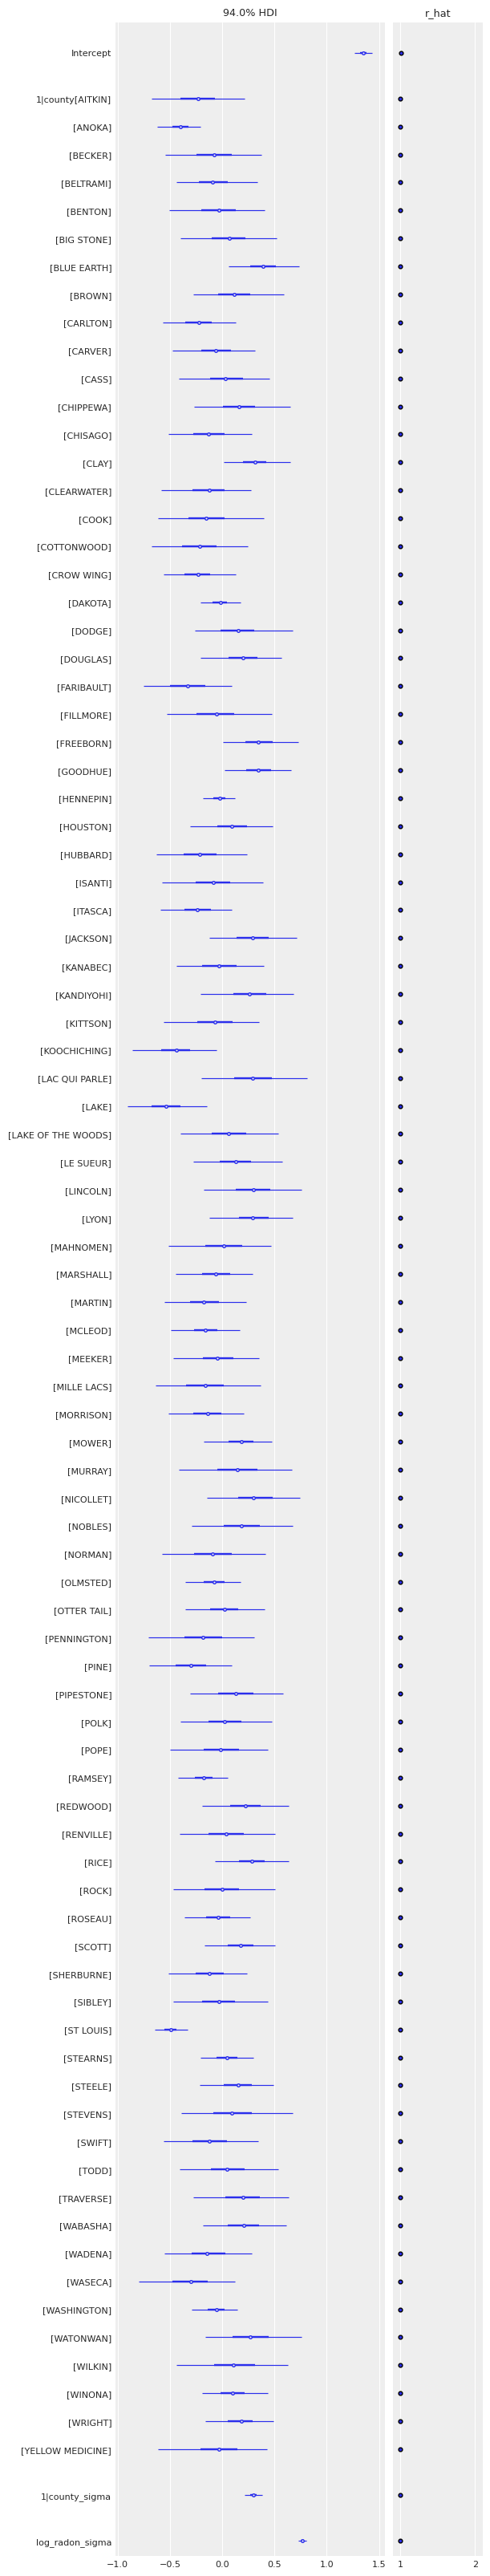

In [29]:
az.plot_forest(data=partial_pooling_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

### Varying Intercept Model

Next, we add the `floor` global feature (i.e. does not depend on the `county`) into the model above. That is,

$$y_i = \alpha_{j[i]} + \beta x_{i} + \varepsilon_i$$

For the Bambi implementation we simply add the term `floor` into the formula. In addition, as we want to keep the complete one-on-encoding of the `floor variable` we need to remove the `Intercept`, which explains the `0` in the model formula below:


In [30]:
varying_intercept_priors = {
    "floor": bmb.Prior(name="Normal", mu=0.0, sigma=10.0),
    "1|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior(name="Exponential", lam=1)),
    "sigma": bmb.Prior(name="Exponential", lam=1),
}

varying_intercept_model = bmb.Model(
    "log_radon ~ 0 + floor + (1|county)",
    srrs_mn,
    priors=varying_intercept_priors,
    link="identity",
    auto_scale=False,
    noncentered=False,
 )

In [31]:
varying_intercept_results = varying_intercept_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, 1|county, 1|county_sigma, floor]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


When looking at the graph representation of the model we still see the hierarchical structure for the `county` varying intercepts, but we do not see it for the `floor` feature as expected.

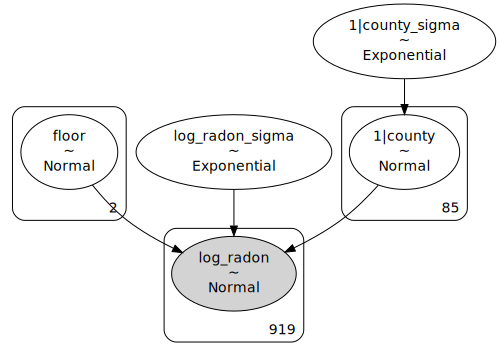

In [32]:
varying_intercept_model.graph()

Let us visualize the posterior distributions:

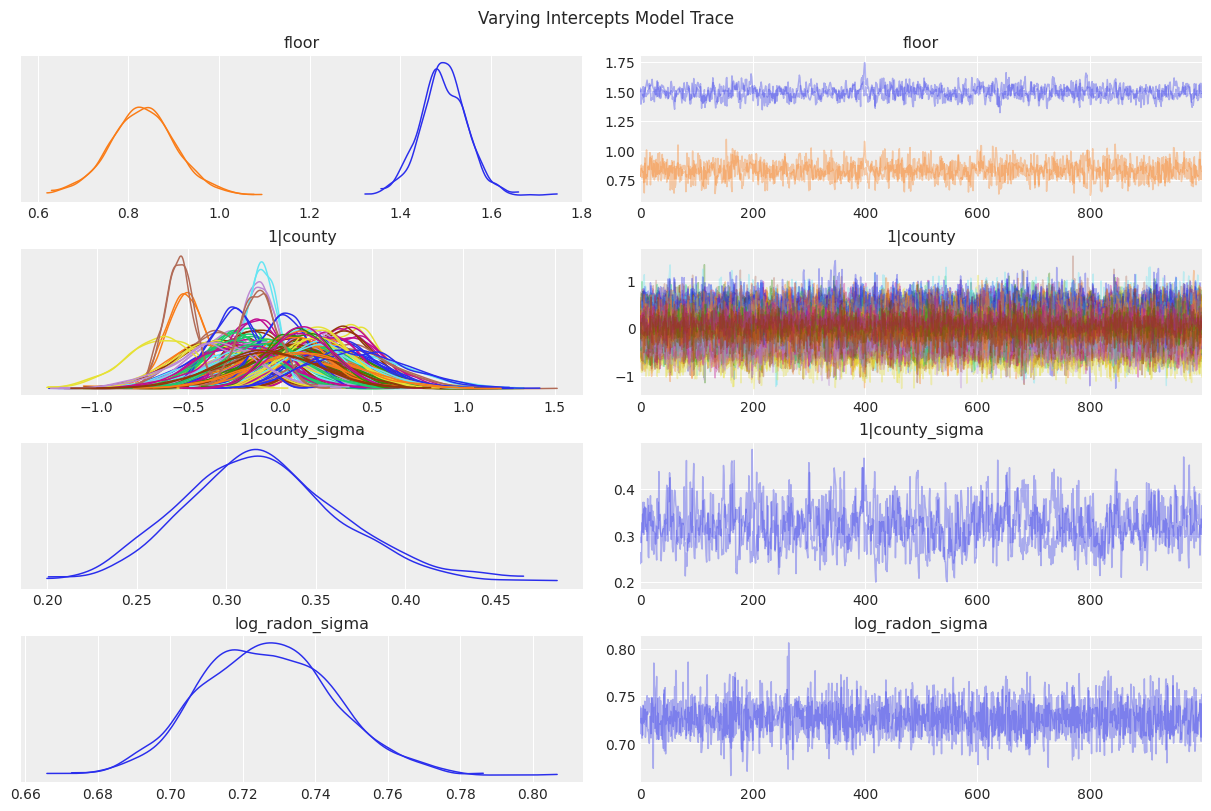

In [33]:
az.plot_trace(data=varying_intercept_results, compact=True, chain_prop={"ls": "-"});
plt.suptitle("Varying Intercepts Model Trace");

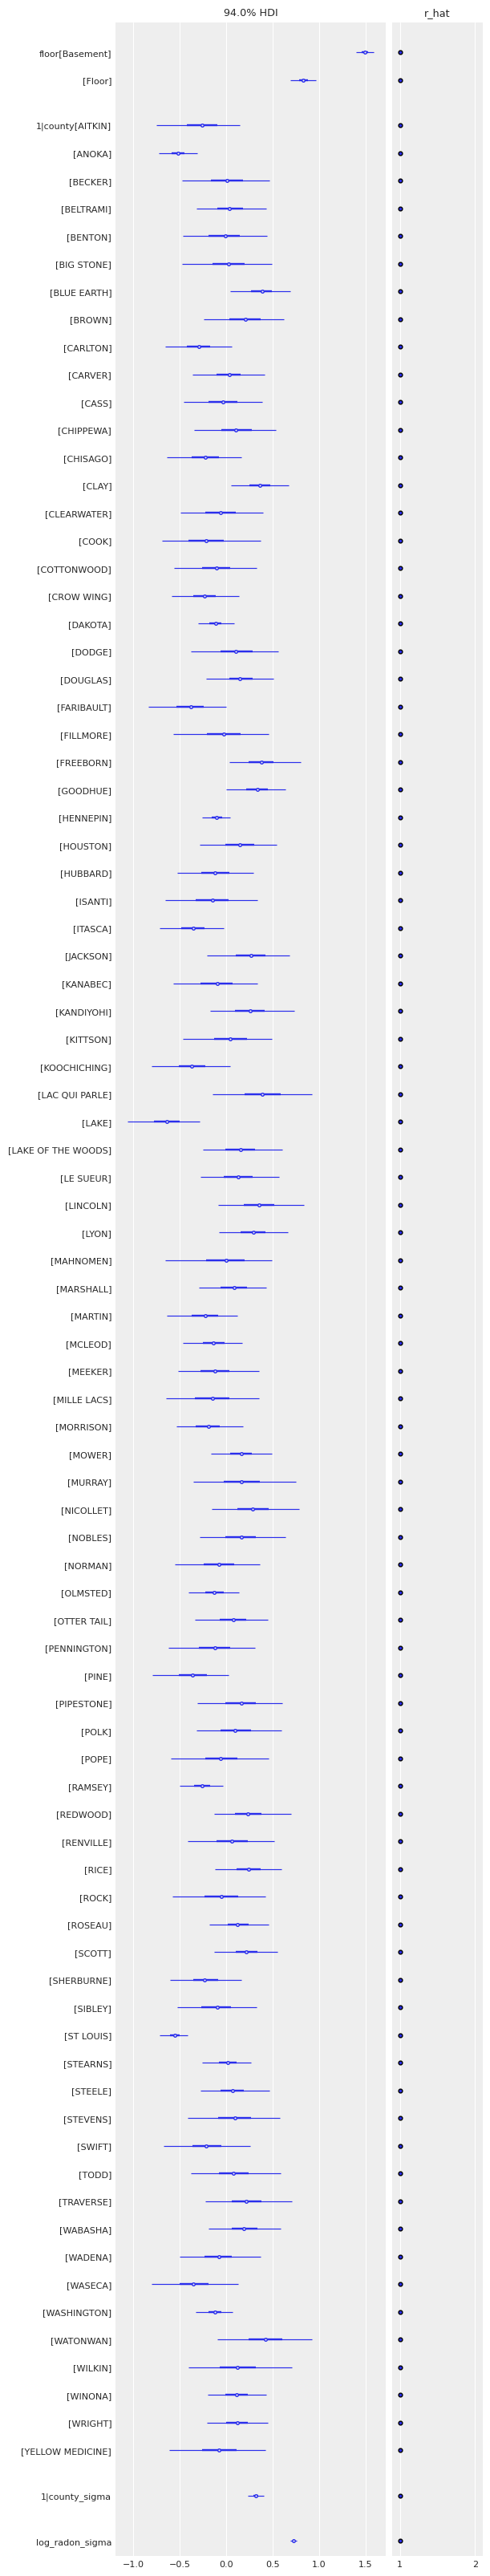

In [34]:
az.plot_forest(data=varying_intercept_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

### Varying Intercept and Slope Model

Next we want to include a hierarchical structure in the `floor` effect, i.e. to consider a model of the form

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \varepsilon_i$$

where $\varepsilon_i \sim N(0, \sigma_y^2)$, intercept random effect is parametrized as $\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$ and the slopes by $\beta_{j[i]} \sim N(\mu_{\beta}, \sigma_{\beta}^2)$. The hyper-prior is specified as 

$$
\begin{align*}
\mu_{\alpha} & \sim N(0, 5^{2}) \\
\sigma_{\alpha} & \sim Exp(1.0) \\
\mu_{\beta} & \sim N(0, 1.0^{2}) \\
\sigma_{\beta} & \sim Exp(0.5)
\end{align*}
$$

In this case the model specification is quite easy, namely `log_radon ~ (floor|county)`. This formula actually represent the following terms:
 - `Intercept`, which encodes the hyper-prior for $\mu_\alpha$.
 - `1|county` represent the varying intercepts.
 - `floor|county` represents the varying slopes.
 - `sigma` is the standard deviation of the errors. 


In [35]:
# ! Where is the specification of the hyper-prior of $\mu_beta$?  
varying_intercept_slope_priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0, sigma=5),
    "1|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior(name="Exponential", lam=1)),
    "floor|county": bmb.Prior(name="Normal", mu=0.0, sigma=bmb.Prior("Exponential", lam=0.5)),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

varying_intercept_slope_model = bmb.Model(
    formula="log_radon ~ (floor|county)",
    data=srrs_mn,
    priors=varying_intercept_slope_priors,
    link="identity",
    auto_scale=False,
    noncentered=False,
 )

varying_intercept_slope_model

Formula: log_radon ~ (floor|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 5)

  Group-level effects
    1|county ~ Normal(mu: 0, sigma: Exponential(lam: 1))
    floor|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 0.5))

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

In [36]:
varying_intercept_slope_results = varying_intercept_slope_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, floor|county, floor|county_sigma, 1|county, 1|county_sigma, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.


In the graph representation of the model we can now see hierarchical structures both in the intercepts and the slopes.

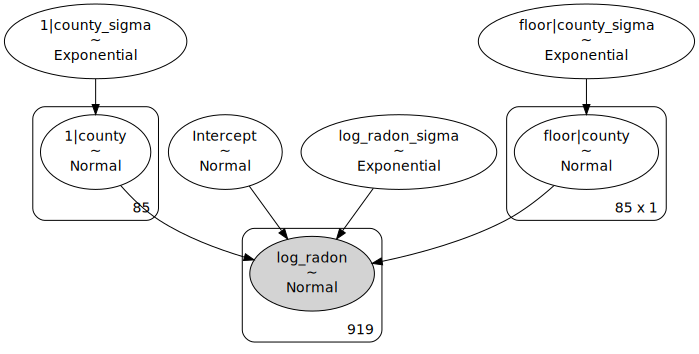

In [37]:
varying_intercept_slope_model.graph()

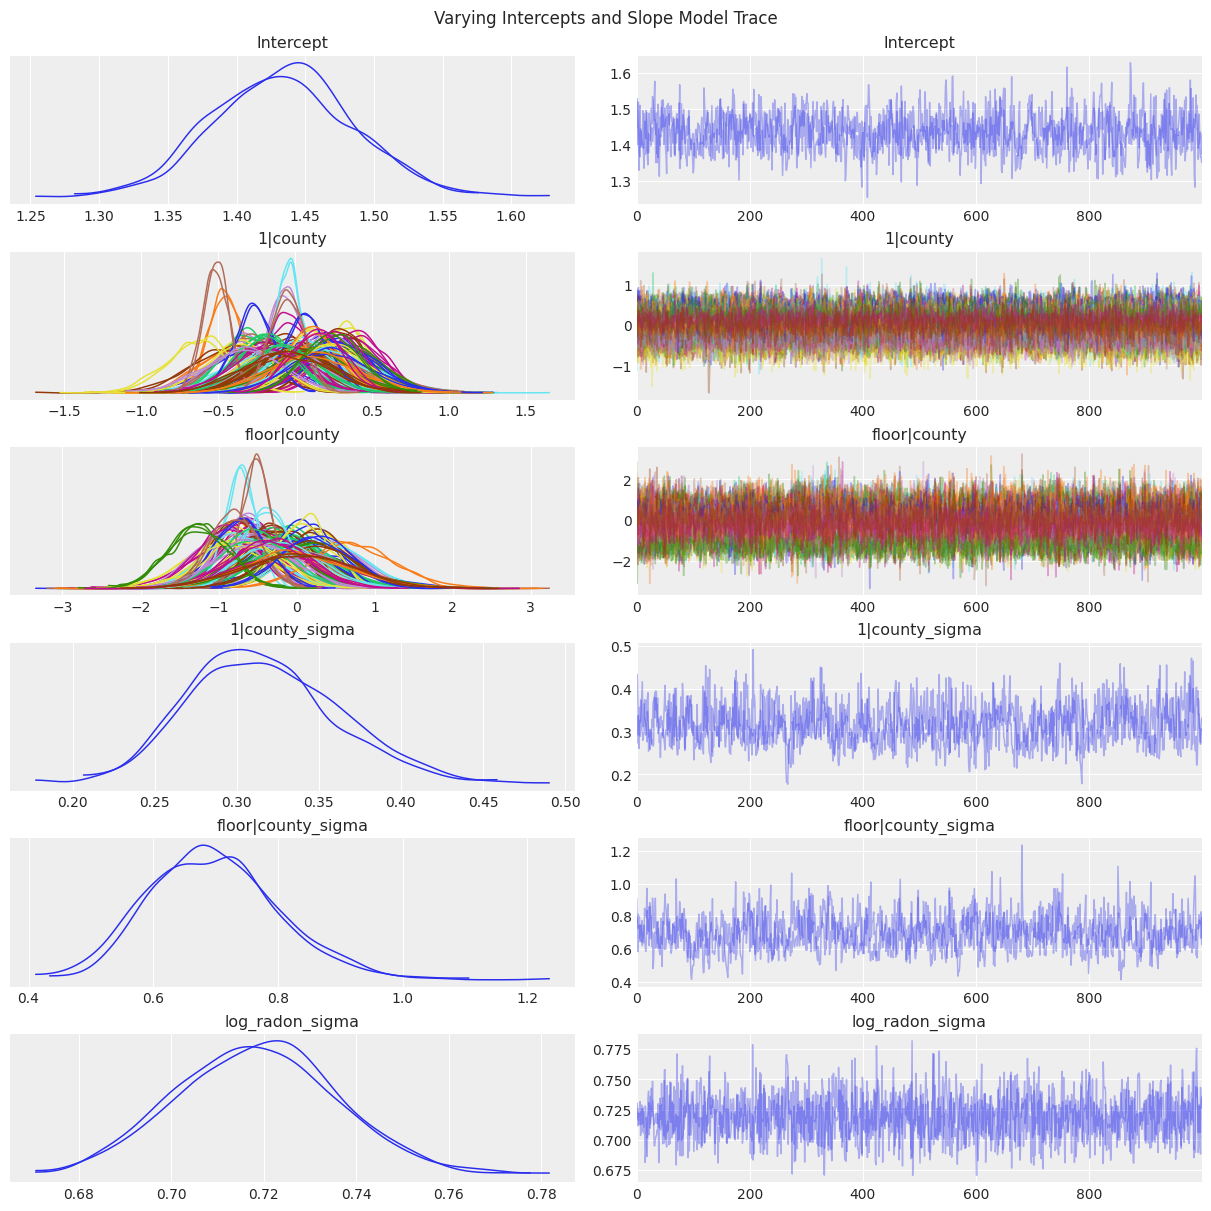

In [38]:
az.plot_trace(data=varying_intercept_slope_results, compact=True, chain_prop={"ls": "-"});
plt.suptitle("Varying Intercepts and Slope Model Trace");

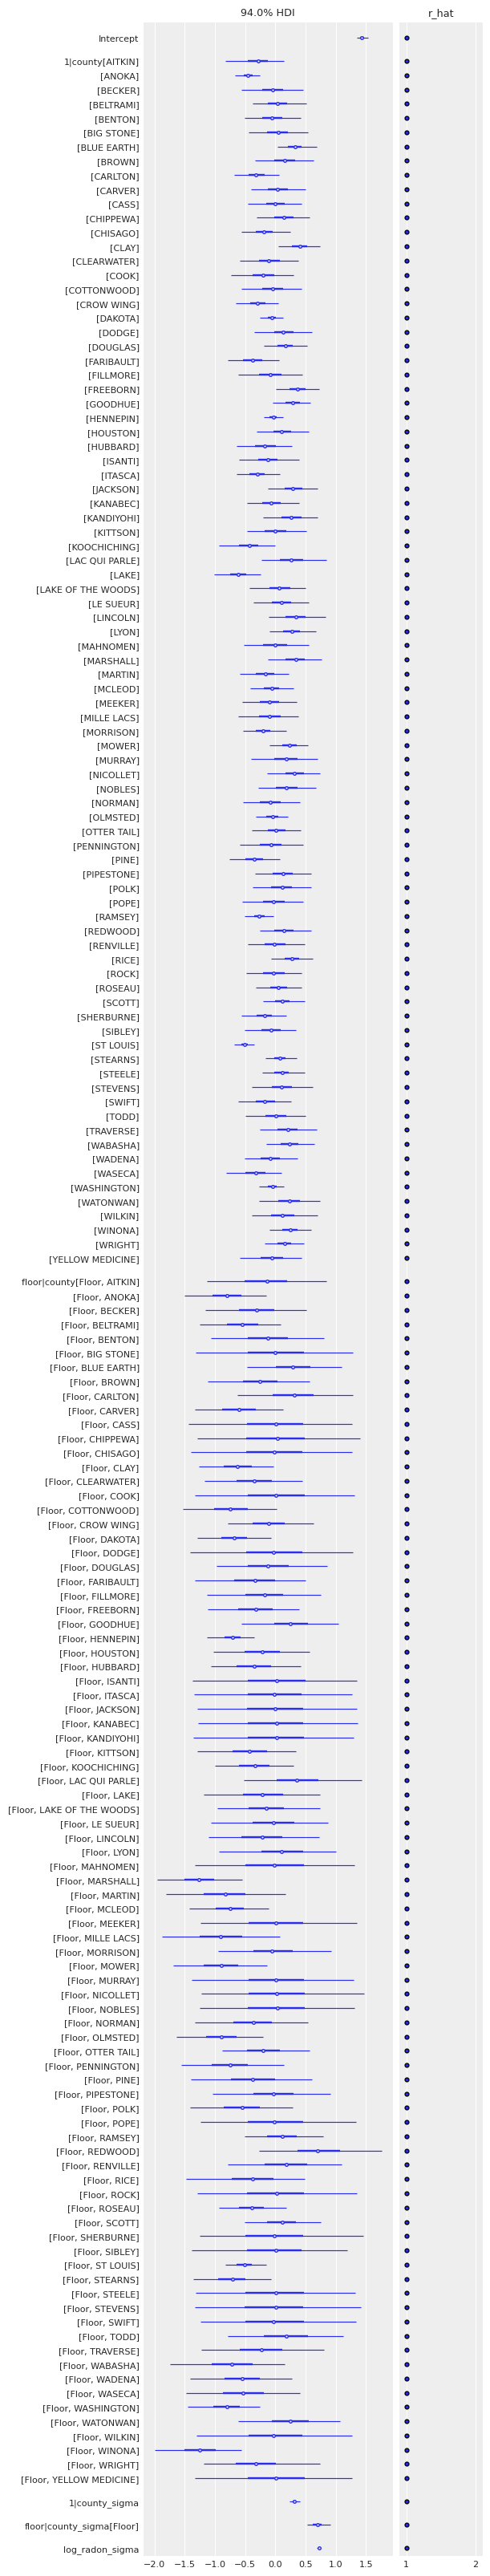

In [39]:
az.plot_forest(data=varying_intercept_slope_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

---

**NOTE:** We can do the following and it "works". But I wouldn't keep this in this notebook because it is still quite experimental and buggy. I'd prefer to fix the implementation and we can update the notebook after that.

In [40]:
priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0, sigma=5),
    "floor|county": bmb.Prior(name="Normal", mu=0.0, sigma=bmb.Prior("HalfNormal", sigma=0.5)),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

model = bmb.Model(
    formula="log_radon ~ (0 + floor|county)",
    data=srrs_mn,
    priors=priors,
    priors_cor={"county": 2}
 )

model.build()

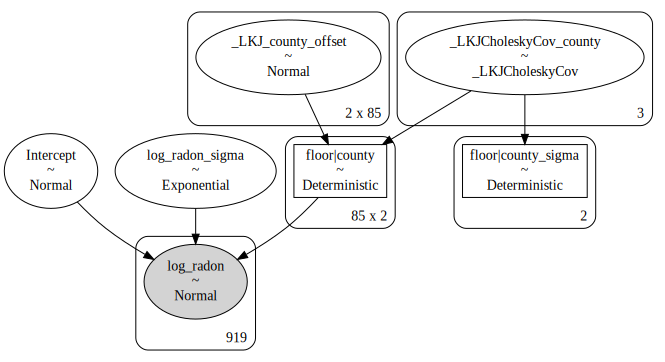

In [ ]:
model.graph()

In [ ]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, _LKJ_county_offset, _LKJCholeskyCov_county, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
The number of effective samples is smaller than 25% for some parameters.


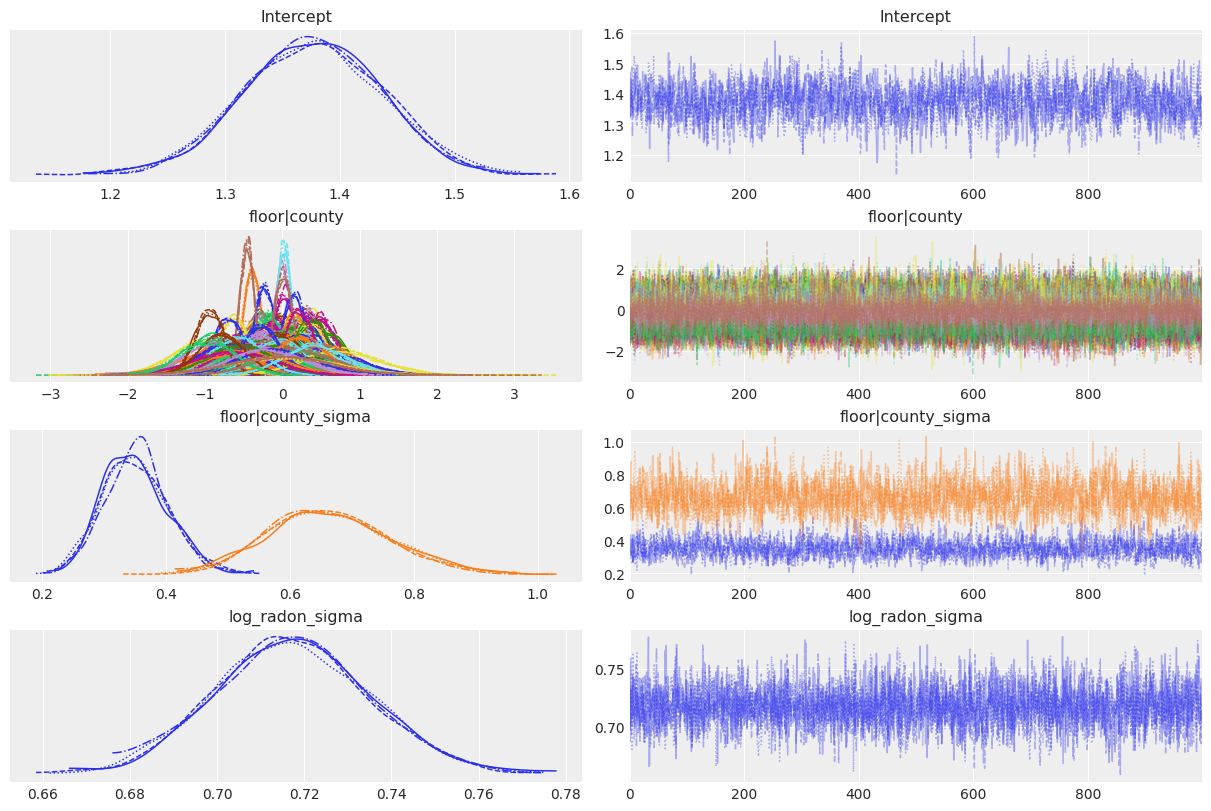

In [ ]:
az.plot_trace(idata);